In [1]:
import torch
import matplotlib.pyplot as plt
import cv2
import pandas as pd


input_folder = "./inputs/70TestDoors"
# output_folder = "./outputs/20220817_181813"
output_folder = "./outputs/newdataset_secondtry"

# Load the trained model 
model = torch.load(output_folder + '/weights.pt')
print(output_folder + 'weights.pt')
# Set the model to evaluate mode
model.eval()

c:\Users\Fred\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


./outputs/newdataset_secondtryweights.pt


DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

In [2]:
# Read the log file using pandas into a dataframe
df = pd.read_csv(output_folder + '/log.csv')

### Training and testing loss, f1_score and auroc values for the model trained on the CrackForest dataset

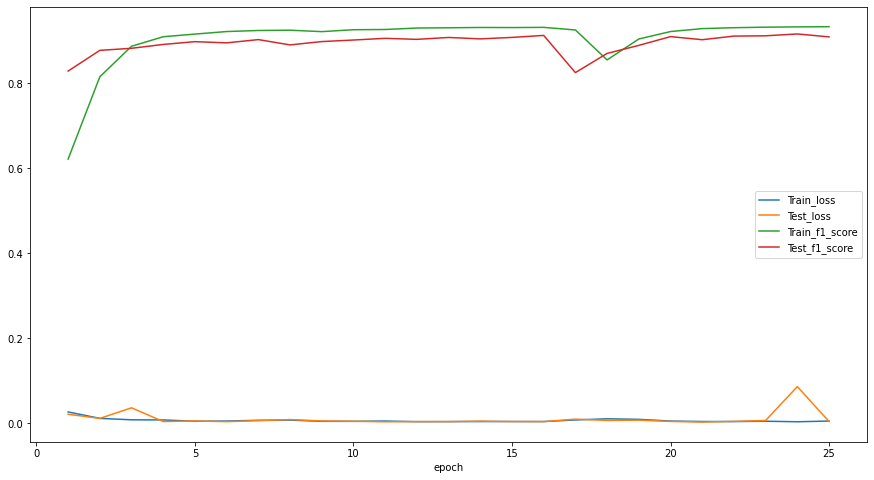

In [3]:
# Plot all the values with respect to the epochs
df.plot(x='epoch',figsize=(15,8));

In [4]:
# print(df[['Train_auroc','Test_auroc']].max())

### Sample Prediction

In [7]:
door = 'Door' + '1800'
print(f'{input_folder}/Masks/{door}.png')

# Read  a sample image from the data-set
img = cv2.imread(f'{input_folder}/Images/{door}.png').transpose(2,0,1).reshape(1,3,640,480)

with torch.no_grad():
    a = model(torch.from_numpy(img).type(torch.cuda.FloatTensor)/255) #/255 makes array of numbers from 0 to 1

./inputs/70TestDoors/Masks/Door1800.png


(array([ 11984., 144646.,  35268.,  26279.,  22364.,  17663.,  12724.,
         16822.,  18414.,   1036.]),
 array([-0.06403126,  0.01254687,  0.089125  ,  0.16570313,  0.24228126,
         0.3188594 ,  0.3954375 ,  0.47201565,  0.54859376,  0.6251719 ,
         0.70175004], dtype=float32),
 <BarContainer object of 10 artists>)

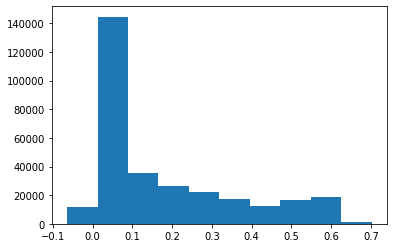

In [8]:
# Plot histogram of the prediction to find a suitable threshold. From the histogram a 0.1 looks like a good choice.
plt.hist(a['out'].data.cpu().numpy().flatten())

In [9]:
import numpy as np
median = np.median(a['out'].data.cpu().numpy().flatten())
print(median)
mean = a['out'].data.cpu().numpy().flatten().mean()
print(mean)

0.08333495
0.17256756


(-0.5, 479.5, 639.5, -0.5)

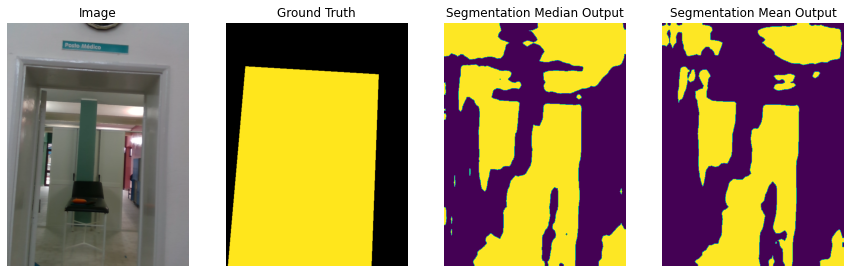

In [10]:
from PIL import Image
# Plot the input image, ground truth and the predicted output
rgb_image = cv2.cvtColor(cv2.imread(f'{input_folder}/Images/{door}.png'), cv2.COLOR_BGR2RGB)
mask = cv2.imread(f'{input_folder}/Masks/{door}.png')

plt.figure(figsize=(15,10))

plt.subplot(141)
plt.imshow(rgb_image)
plt.title('Image')
plt.axis('off')

plt.subplot(142)
plt.imshow(mask)
plt.title('Ground Truth')
plt.axis('off')

plt.subplot(143)
#here need to find largest blob
#WRITE CODEEEEEEE

median_img_array = a['out'].cpu().detach().numpy()[0][0]> median
median_img_object = Image.fromarray(median_img_array)
plt.imshow(median_img_array)
plt.title('Segmentation Median Output')
plt.axis('off')

plt.subplot(144)
plt.imshow(a['out'].cpu().detach().numpy()[0][0]> mean)
plt.title('Segmentation Mean Output')
plt.axis('off')
# # plt.savefig('./DoorsMediumExp/SegmentationOutput.png',bbox_inches='tight')

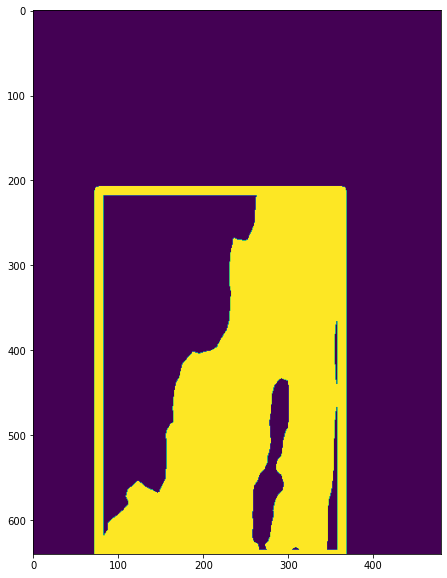

In [11]:
#https://stackoverflow.com/questions/56589691/how-to-leave-only-the-largest-blob-in-an-image 
# Read image as black and white instead of true or false
input_img = median_img_array * np.uint8(255)
# Generate intermediate image; use morphological closing to keep parts of the brain together
inter = cv2.morphologyEx(input_img, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5)))

# Find largest contour in intermediate image
contours, _ = cv2.findContours(inter, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
biggest_c = max(contours, key=cv2.contourArea)
x,y,w,h = cv2.boundingRect(biggest_c)

# Output
out = np.zeros(inter.shape, np.uint8)
out = cv2.bitwise_and(input_img, out)
# draw the biggest contour (c) in green
cv2.drawContours(out, [biggest_c], -1, 255, cv2.FILLED)
cv2.rectangle(out,(x,y),(x+w,y+h),255,10)

plt.figure(figsize=(15,10))
plt.imshow(out)
# cv2.imshow('out', out)
# cv2.waitKey(0)